# Exploratory Data Analysis

## Executive Summary

In this file we studied the effects of various factors on the loan status distribution. The following provides a summary of findings:

Length of employment, as well as home ownership is not a great predictor of fate of a loan

Applicants with higher credit scores are also better borrowers and it is shown that defaulted loans have applicants with lower credit scores.

Previous charged off accounts or bankruptcies in an applicant's credit history or the length of the applicant's credit history do not affect how he/she performs on his/her loan return. Furthermore, the applicant's balance and how musch he/she uses their credit on the time of application (ie utilization rate) do not affect how he/she will return the loan. While, the nuumbr of credit accounts an applicant owns is not a determinant in the fate of a loan, applicants with more mortages tend to perform better.

As the installment increases, the probability of a loan defaultation also increases. Furthermore, higher interest rates also result in higher chance of default. Also, while 30% of loans with 30 month return period default, this value doubles for loans with 60 month return period.

DTI, debt-to-income ratio which compares an applicant's total monthly debt obligations to their monthly gross income is a good predictor of default, and as DTI increases chances of defaultation also increases.

There are 35 grades for loans starting from A1 and ending in G5. Briefly, as a loan moves from A1 to G5, the riskier the loan will be. It is clear from the chart of Loan distribution vs grade that as loan grade decreases from A1 to G5, the probability of deafualting increases; while less than 10% of grade-A loans default, there is about 50% probability that a G-grade loan defaults. So, grade can be a strong predictor of if a loan defaults. Furthermore, as shown moving from A1 grade to G5, interest rate also increases. It is seen that in G category, the interest rate reaches a plateau of about 30%.

We also checked to see if the state where an applicant lives affect how they perform on their loans. while in some states more number of loans are issued per capita, applicants in different states are similar in their loan performance.

Principle component analysis on the numerical features also showed that, loan amount, dti, Fico scores and revolving balance are important in the first 2 principle components. Only about 32% of the variance is explained by the first two componenets.

We should note that, installment and interest rate, as well as subgrade are features determined by the lending club based on an application.

## Introduction<a id='3.21_Introduction'></a>

In this section, we will explore the features contributing to the default of a loan. As described in the wrangling part, the aim
for this project is to predict whether borrower will deault their loan. This means that we only consider those features that were 
recorded at the time of application, such as income, FICO high and low, number of delinuent accounts, purpose of the loan, employment length, etc. 

## Imports

In [499]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from library.sb_utils import save_file
import datetime as dt
import math
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [500]:
%watermark -a "Saeed Rafieepour" -d -t -v -p numpy,pandas

Author: Saeed Rafieepour

Python implementation: CPython
Python version       : 3.12.1
IPython version      : 8.20.0

numpy : 1.26.4
pandas: 2.2.0



#### Project Directory and Load user defined functions accross multiple notebooks

In [501]:
os.getcwd()
PROJ_ROOT = os.path.join(os.pardir, os.pardir)
cleaned_data = os.path.join(PROJ_ROOT, 'data', 'wrangled', 'cleaned_data.csv')
state_summary = os.path.join(PROJ_ROOT, 'data', 'raw', 'state_summary.csv')
states_name = os.path.join(PROJ_ROOT, 'data', 'raw', 'states_name.csv')
sys.path.append(cleaned_data)
sys.path.append(state_summary)
sys.path.append(states_name)

In [502]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)

# import my method from the source code
%aimport features.feature_builder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [503]:
# import my method from the source code
import features.feature_builder as fb
from features.feature_builder import feature_describe
from features.feature_builder import get_data_type

## Load The Data

### Loan data

In [504]:
loan_data = pd.read_csv(cleaned_data, sep='\t')

In [505]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194547 entries, 0 to 1194546
Data columns (total 37 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Unnamed: 0                  1194547 non-null  int64  
 1   revol_util                  1194547 non-null  float64
 2   dti                         1194547 non-null  float64
 3   chargeoff_within_12_mths    1194547 non-null  float64
 4   collections_12_mths_ex_med  1194547 non-null  float64
 5   inq_last_6mths              1194547 non-null  float64
 6   earliest_cr_line            1194547 non-null  object 
 7   open_acc                    1194547 non-null  float64
 8   mort_acc                    1194547 non-null  float64
 9   annual_inc                  1194547 non-null  float64
 10  issue_d                     1194547 non-null  object 
 11  grade                       1194547 non-null  object 
 12  sub_grade                   1194547 non-null  object 
 1

In [506]:
loan_data.head()

,Unnamed: 0,revol_util,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,earliest_cr_line,open_acc,mort_acc,annual_inc,...,addr_state,loan_amnt,purpose,verification_status,tot_hi_cred_lim,pub_rec,delinq_2yrs,delinq_amnt,acc_now_delinq,bc_util
0,0,29.7,5.91,0.0,0.0,1.0,2003-08-01,7.0,1.0,55000.0,...,PA,3600.0,debt_consolidation,Not Verified,178050.0,0.0,0.0,0.0,0.0,37.2
1,1,19.2,16.06,0.0,0.0,4.0,1999-12-01,22.0,4.0,65000.0,...,SD,24700.0,other,Not Verified,314017.0,0.0,1.0,0.0,0.0,27.1
2,4,64.5,25.37,0.0,0.0,3.0,1998-06-01,12.0,6.0,104433.0,...,PA,10400.0,other,Source Verified,439570.0,0.0,1.0,0.0,0.0,77.5
3,5,68.4,10.20,0.0,0.0,0.0,1987-10-01,5.0,0.0,34000.0,...,GA,11950.0,debt_consolidation,Source Verified,16900.0,0.0,0.0,0.0,0.0,91.0
4,6,84.5,14.67,0.0,0.0,0.0,1990-06-01,12.0,4.0,180000.0,...,MN,20000.0,debt_consolidation,Not Verified,388852.0,0.0,0.0,0.0,0.0,102.9


In [507]:
loan_data.drop(columns = ['Unnamed: 0'], axis=1, inplace = True)

Just to refresh, let's see what are the descriptions of all the features selected. 

In [508]:
pd.options.display.max_colwidth =  None
feature_describe(loan_data.columns.to_list())

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
2,addr_state,The state provided by the borrower in the loan application
4,annual_inc,The self-reported annual income provided by the borrower during registration.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.
10,chargeoff_within_12_mths,Number of charge-offs within 12 months
12,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
13,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
14,delinq_amnt,The past-due amount owed for the accounts on which the borrower is now delinquent.
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
18,earliest_cr_line,The month the borrower's earliest reported credit line was opened


#### Heatmap of the features

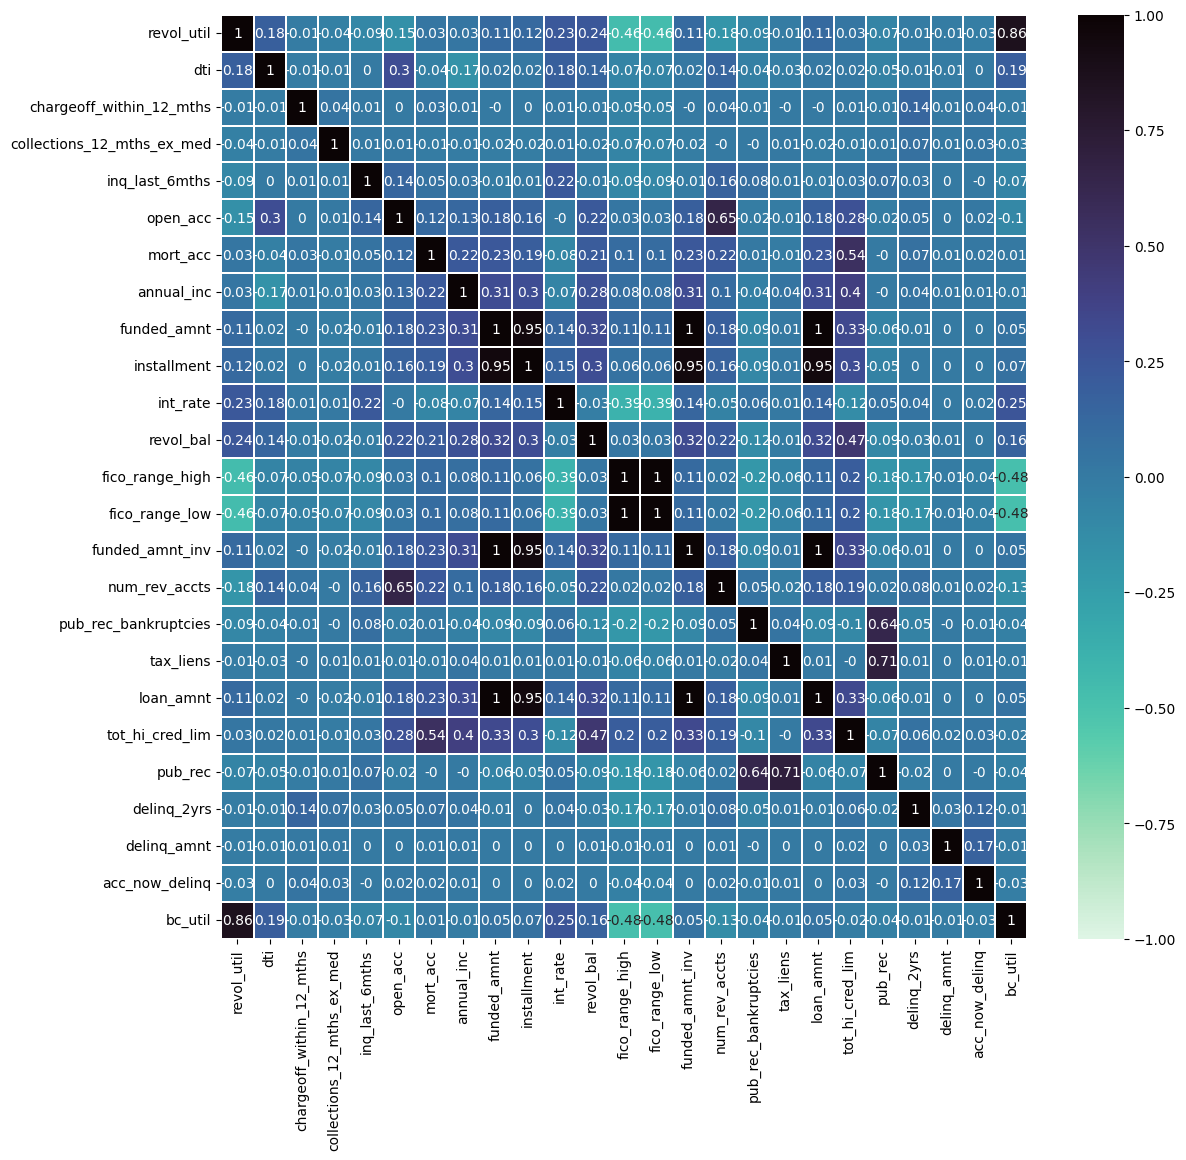

In [509]:
plt.figure(figsize = (13,12))
sns.color_palette("flare", as_cmap=True)
correlation_ = loan_data.select_dtypes(include=['float64']).corr().round(2)
sns.heatmap(correlation_, xticklabels=correlation_.columns, yticklabels=correlation_.columns,cmap = 'mako_r', linewidths=.3, vmin=-1, vmax=1, 
            annot=True);

It seems that loan_amnt, funded_amnt, funded_amnt_inv, and installment are highly corrolated. let's see what are these:

In [510]:
feature_describe(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment'])

,LoanStatNew,Description
23,funded_amnt,The total amount committed to that loan at that point in time.
24,funded_amnt_inv,The total amount committed by investors for that loan at that point in time.
33,installment,The monthly payment owed by the borrower if the loan originates.
41,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."


In [511]:
try:
    df1 = loan_data[['loan_amnt']]
    df2 = loan_data[['installment']].rename(columns={'installment':'loan_amnt'})
    pd.testing.assert_frame_equal (df1, df2 )
except:
    print("assert not satisfied")

assert not satisfied


In [512]:
try:
    df1 = loan_data[['loan_amnt']]
    df2 = loan_data[['funded_amnt_inv']].rename(columns={'funded_amnt_inv':'loan_amnt'})
    pd.testing.assert_frame_equal (df1, df2 )
except:
    print("assert not satisfied")

assert not satisfied


In [513]:
try:
    df1 = loan_data[['funded_amnt']]
    df2 = loan_data[['loan_amnt']].rename(columns={'loan_amnt':'funded_amnt'})
    pd.testing.assert_frame_equal (df1, df2 )
except:
    print('assert was not satisfied')

assert was not satisfied


In [514]:
try:
    df1 = loan_data[['funded_amnt']]
    df2 = loan_data[['funded_amnt_inv']].rename(columns={'funded_amnt_inv':'funded_amnt'})
    pd.testing.assert_frame_equal (df1, df2 )
except:
    print('assert was not satisfied')

assert was not satisfied


The analysis showed that funded_amnt and loan_amnt are very close (only 0.00067 % different). This means that these columns are not exactly the same.
As the description shows, for example, the loan_amnt shows that it may drop from the funded value over time, and if drops, it is reflected in the loan_amnt. We'll keep all the three variables.

The other two features that needs further explorations are bc_util and revol_util. They show high correlations (0.86).

In [515]:
feature_describe(['bc_util', 'revol_util'])

,LoanStatNew,Description
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.
91,revol_util,"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."


In [516]:
loan_data[['bc_util', 'revol_util']]

,bc_util,revol_util
0,37.2,29.7
1,27.1,19.2
2,77.5,64.5
3,91.0,68.4
4,102.9,84.5
...,...,...
1194542,68.2,34.0
1194543,69.4,85.2
1194544,10.6,27.4
1194545,73.1,55.0


In [517]:
diff = loan_data['bc_util'] - loan_data['revol_util']

In [518]:
(diff<0).value_counts()

False    995695
True     198852
Name: count, dtype: int64

Both of these show the ratio between the credit being used to the total credits, and the difference is both positive and negative. It is not clear, however, in the ratio for bc_util, the high credit/credict limit refers to the maximum credit limit of all the bankcards or just one bankcard? The fact, however, is that these two are ratio of debts-to-credit limit, and thus we can use the average of the two to avoid similar features.

In [519]:
loan_data['util'] = loan_data.apply(lambda row: 0.5 * (row['bc_util'] + row['revol_util']), axis=1)

In [520]:
loan_data.drop(['bc_util', 'revol_util'], axis =1, inplace=True)

In [521]:
loan_data.shape

(1194547, 35)

In [522]:
# using df instead of loan_data
df = loan_data

### Distribution of loan status

The loans in the original dataset are in 5 categories: Current, Fully paid, Charged-off, Default and Late.The scope of this project is a binary classification; therefore, Current loans are dropped. We'll use the current values later as a test set for predicting whether or not a borrower defaults. A closer look at the data revealed that default is when the borrower is late and charged off happens when the creditor gives up hope on getting the loan back. So, default is the beginning of the process which may or may not lead to charge off. Therefore, Charged-off and Default categories were combined in one category and is called Default. This was done in the wrangling part of the project. Here is the final distribution.

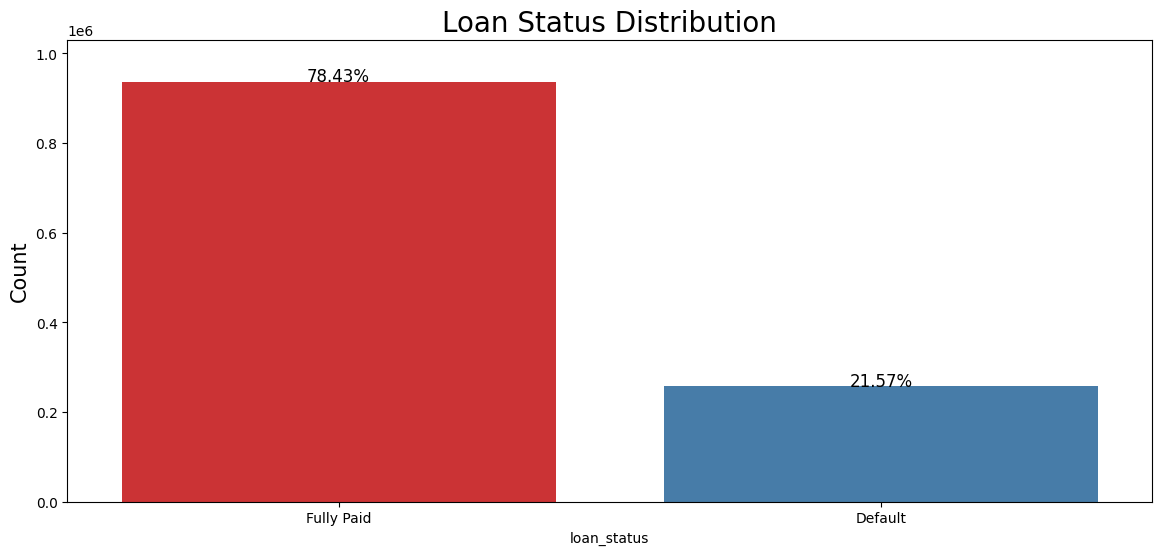

In [523]:
total = len(df)

plt.figure(figsize = (14,6))

ax = sns.countplot(x="loan_status", data=df, palette="Set1", legend=False, hue = "loan_status")
#ax.set_xticklabels(ax.get_xticklabels(),rotation=45, fontsize=14)
#ax.set_xlabel("Loan Status Categories", fontsize=14)
ax.set_ylabel("Count", fontsize=15)
ax.set_title("Loan Status Distribution", fontsize=20)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
ax.set_ylim(0, max(sizes) * 1.10)

plt.show()

### Sensitivity study of loan status to other features

Let's convert the date-time columns of object data types to datetime formats. The date columns are:

In [524]:
# date columns
date_col = ['earliest_cr_line', 'issue_d']

In [525]:
df = fb.stringdate_to_datetime(df, date_col)

In [562]:
df['issue_year'] = df[['issue_d']].apply(lambda x: x.dt.year)

#### Loan status distribution vs year

In [526]:
# note that .loc we can use booleans and a list of column names to filter the dataframe and produce a dataframe
# if we only use 'issue_d'
fully_paid = df.loc[df.loan_status=='Fully Paid', ['issue_d']].apply(lambda x: x.dt.year).value_counts()
defaulted = df.loc[df.loan_status=='Default', ['issue_d']].apply(lambda x: x.dt.year).value_counts()

In [527]:
type(defaulted)

pandas.core.series.Series

In [529]:
loanStat_countPerYear = pd.DataFrame({'Fully Paid': fully_paid, 'Default': defaulted})
loanStat_countPerYear['Total'] =  loanStat_countPerYear['Fully Paid'] + loanStat_countPerYear['Default']
loanStat_countPerYear.index = ['2012', '2013', '2014', '2015', '2016', '2017', '2018']

# the following codes do all we did previously
'''
default = df.groupby(['loan_status', 'issue_year'])[['issue_year']].count().loc['Default']
Fully_paid = df.groupby(['loan_status', 'issue_year'])[['issue_year']].count().loc['Fully Paid']
s = pd.DataFrame({'Fully Paid': Fully_paid.iloc[:,0], 'Default': default.iloc[:,0]})
'''

"\ndefault = df.groupby(['loan_status', 'issue_year'])[['issue_year']].count().loc['Default']\nFully_paid = df.groupby(['loan_status', 'issue_year'])[['issue_year']].count().loc['Fully Paid']\ns = pd.DataFrame({'Fully Paid': Fully_paid.iloc[:,0], 'Default': default.iloc[:,0]})\n"

In [530]:
loanStat_countPerYear.head()

,Fully Paid,Default,Total
2012,20625,3773,24398
2013,108137,19682,127819
2014,171291,38538,209829
2015,280184,71561,351745
2016,206028,66917,272945


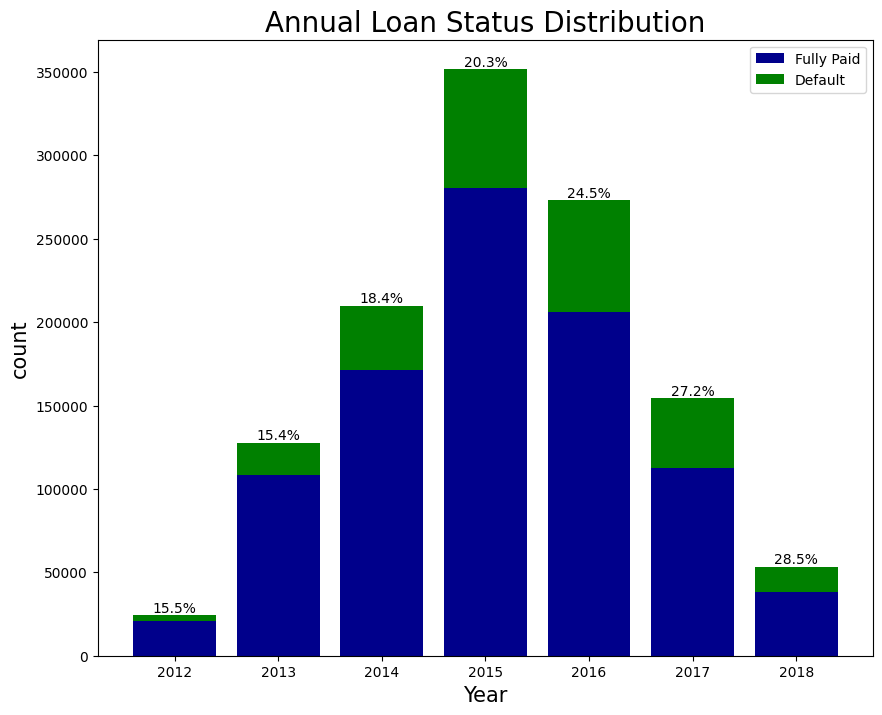

In [532]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(loanStat_countPerYear.index, loanStat_countPerYear['Fully Paid'],  color='darkblue')
ax.bar(loanStat_countPerYear.index, loanStat_countPerYear['Default'], bottom=loanStat_countPerYear['Fully Paid'], color='green')
#ax.set_xticklabels(loanStat_countPerYear.index,)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('count', fontsize=15)
ax.legend(['Fully Paid', 'Default'])
ax.set_title("Annual Loan Status Distribution", fontsize=20)

# annotations
total=loanStat_countPerYear['Total']
ss = loanStat_countPerYear.iloc[:, 0:2]
s_rel = ss.div(total, 0)*100
n = 'Default'
for i, (cs, pc) in enumerate(zip(ss.cumsum(1)[n], s_rel[n])):
    plt.text(i, cs, str(np.round(pc, 1)) + '%', va='bottom', ha='center')

plt.show()

According to this plot, in 2015, majority of the loans were issued. Among non-current loans, 2016, has the highest rate of default, and is the second highest issued loans.

#### Loan status distribution vs home ownership 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


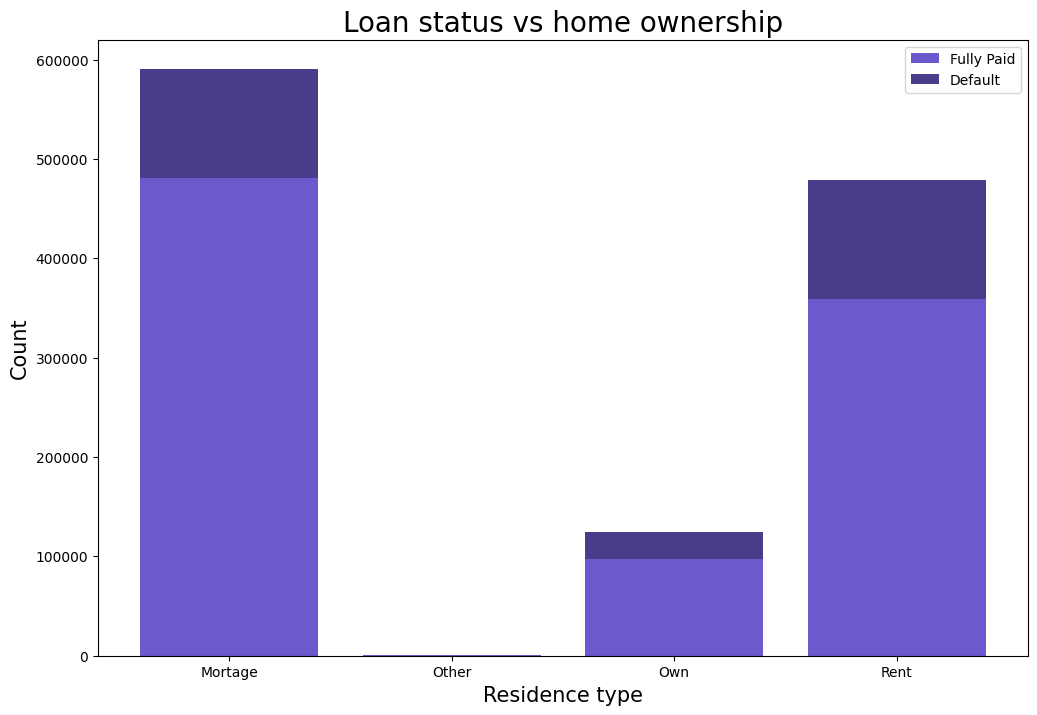

In [533]:
df_ownership = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', ['home_ownership']].value_counts(), 'Default': df.loc[df['loan_status']=='Default', ['home_ownership']].value_counts()})
df_ownership['Total'] = df_ownership['Default'] + df_ownership['Fully Paid']
df_ownership.index=[ 'Mortage', 'Other', 'Own', 'Rent']

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(df_ownership.index, df_ownership['Fully Paid'], color="slateblue")
ax.bar(df_ownership.index, df_ownership['Default'], bottom=df_ownership['Fully Paid'], color='darkslateblue')
#ax.set_xticklabels(s.index, rotation=45)
ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Residence type', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title("Loan status vs home ownership", fontsize=20)


s_total=df_ownership['Total']
df_ownership = df_ownership.iloc[:, 0:2]

s_rel = df_ownership.div(s_total, 0)*100

n = 'Default'
for i, (cs, pc) in enumerate(zip(s.cumsum(1)[n], s_rel[n])):
    plt.text(i, cs, str(np.round(pc, 1)) + '%', va='bottom', ha='center')

plt.show()                      

As shown in the bar plot, majority of applicants live either in their own house, a rental place or mortage. In all these categories the percentages of default is almost the same. Therefore, home ownership cannot be a strong predictor for loan defaultation. 

#### Loan status distribution vs annual income

We next examine the distribution of loan status with respect to the annual income. 

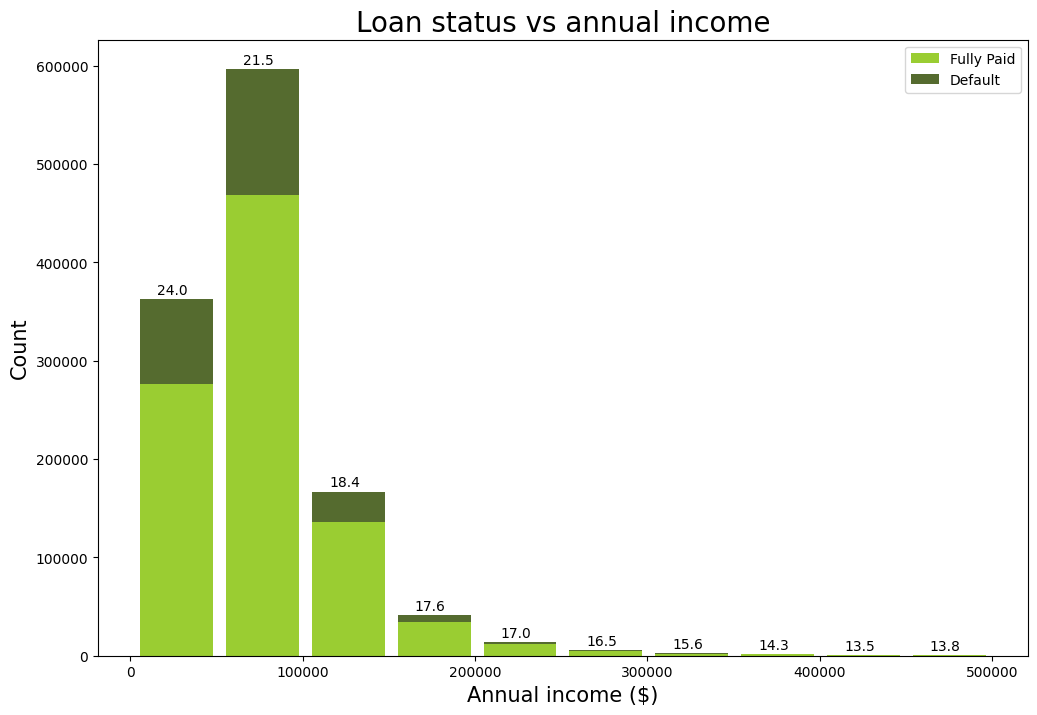

In [534]:
df_income = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'annual_inc'], 'Default':df.loc[df['loan_status']=='Default', 
                          'annual_inc']}, index=None)
df_income = df_income[(df_income['Fully Paid'] < 500000) | (df_income['Default'] < 500000)]
fig, ax = plt.subplots() 

df_income.plot.hist(stacked=True, bins=10, rwidth=0.85, figsize=(12, 8), color=["yellowgreen", "darkolivegreen"], ax=ax)


#axes[0].set_xticklabels(s.index, rotation=45)
ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Annual income ($)', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title("Loan status vs annual income", fontsize=20)


p = ax.patches
for i in range(0,10,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + 10000
    Y1 = p[i].get_height()
    Y2 = p[i+10].get_height()
    y = Y2 + Y1 +5000
    a = Y2/(Y2 + Y1)
    ax.text(x, y, round(a*100,1), rotation=0)

From this plot, it is clear that as the income increases, the rate of the default drops. 

#### Loan status distribution vs employment length

There are 11 different categories of employment length. The following shows how the default percentage changes with emp_len.

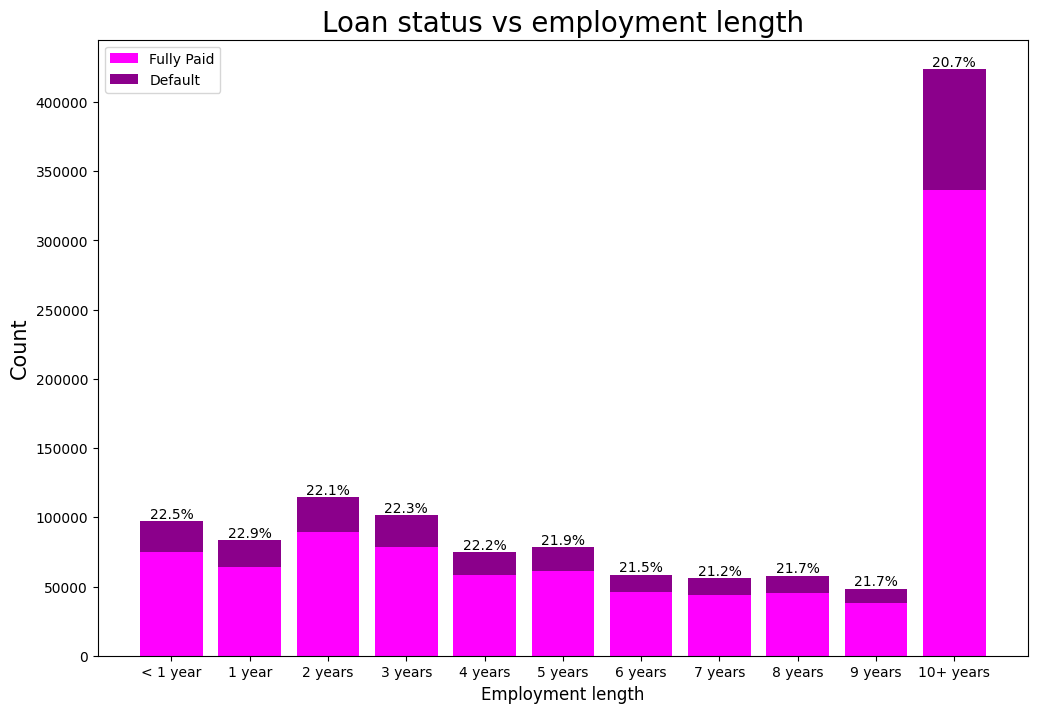

In [536]:
df_emp_len = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', ['emp_length']].value_counts(), 'Default': df.loc[df['loan_status']=='Default', ['emp_length']].value_counts()})
listIndex = df_emp_len.index

df_emp_len.index = [''.join(item) for item in listIndex]


df_emp_len = df_emp_len.reindex(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years',
    '7 years', '8 years', '9 years', '10+ years'])

df_emp_len['Total'] = df_emp_len.apply(lambda row:row['Default'] + row['Fully Paid'], axis=1)

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(df_emp_len.index, df_emp_len['Fully Paid'], color='magenta')
ax.bar(df_emp_len.index, df_emp_len['Default'], bottom=df_emp_len['Fully Paid'], color='darkmagenta')
ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Employment length', fontsize=12)
ax.set_ylabel('Count', fontsize=15)
ax.set_title("Loan status vs employment length", fontsize=20)


s_total=df_emp_len['Total']
df_emp_len = df_emp_len.iloc[:, 0:2]
s_rel = df_emp_len.div(s_total, 0)*100

n = 'Default'
for i, (cs, pc) in enumerate(zip(df_emp_len.cumsum(1)[n], s_rel[n])):
    plt.text(i, cs, str(np.round(pc, 1)) + '%', va='bottom', ha='center')

plt.show()

The above figure clearly shows that the length of employment does not affect the loan default percentage by whole lot as the
default percentage is roughly the same for all the employment length ranges (around 21%)

#### Loan status distribution vs sub-grade


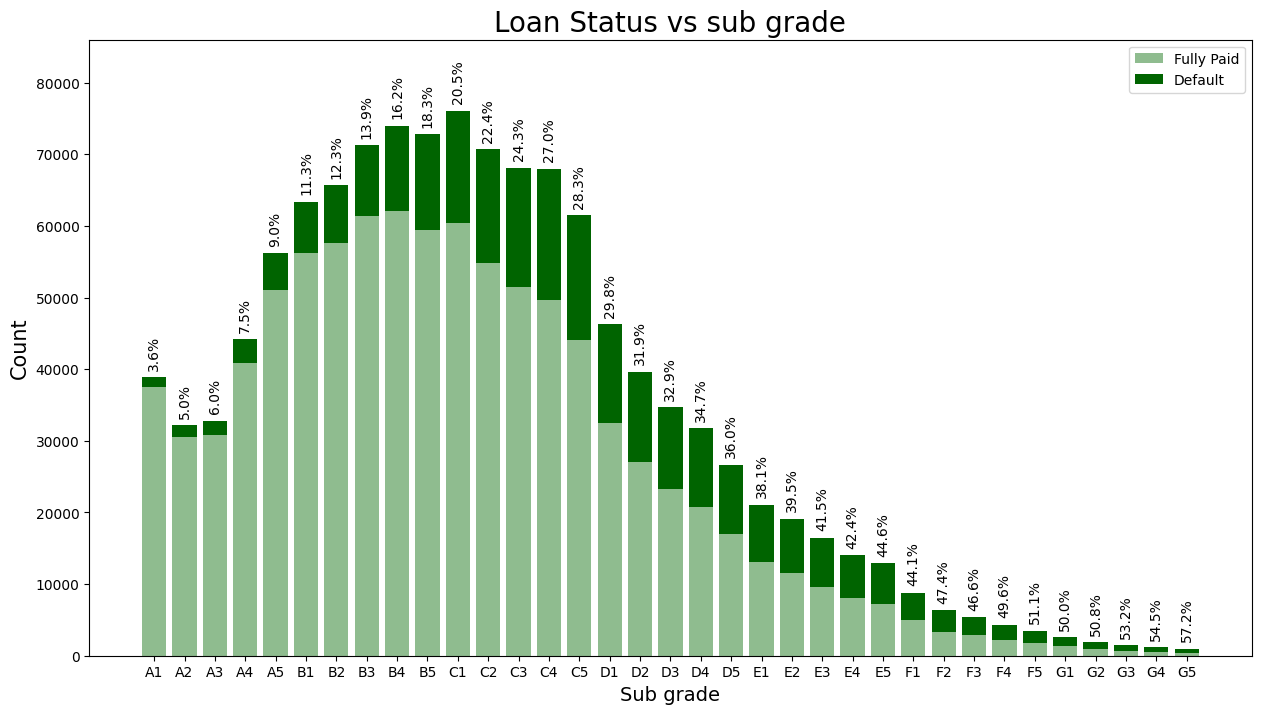

In [537]:
df_sub_grade = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', ['sub_grade']].value_counts(), 'Default': df.loc[df['loan_status']=='Default', ['sub_grade']].value_counts()})
df_sub_grade.index=['A1','A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4',
                                            'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3',
                                            'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']
df_sub_grade['Total'] = df_sub_grade['Default'] + df_sub_grade['Fully Paid']
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(df_sub_grade.index, df_sub_grade['Fully Paid'], color='darkseagreen')
ax.bar(df_sub_grade.index, df_sub_grade['Default'], bottom=df_sub_grade['Fully Paid'], color='darkgreen')
ax.legend(['Fully Paid', 'Default'])
ax.set_ylim(0,86000)
ax.set_xlabel('Sub grade', fontsize=14)
ax.set_ylabel('Count', fontsize=15)
ax.legend(['Fully Paid', 'Default'])
ax.set_title("Loan Status vs sub grade", fontsize=20)

s_total=df_sub_grade['Total']
df_sub_grade = df_sub_grade.iloc[:, 0:2]
s_rel = df_sub_grade.div(s_total, 0)*100

n = 'Default'
for i, (cs, pc) in enumerate(zip(df_sub_grade.cumsum(1)[n], s_rel[n])):
    plt.text(i, cs+1000 , str(np.round(pc,1)) + '%', va='bottom', ha='center', rotation=90)
plt.show()

As shown in this plot, the percentage of default increases from grade A to G. For instance, the grade A loans show as low as 3.6% default rate while the class G loans show as high as 57% default rate. We conclude that the loan subgrade plays a significant role in the default prediction.

### 7.7. Loan status distribution vs installment, interest rate, loan amount and loan term <a class='anchor' id='installment'></a>

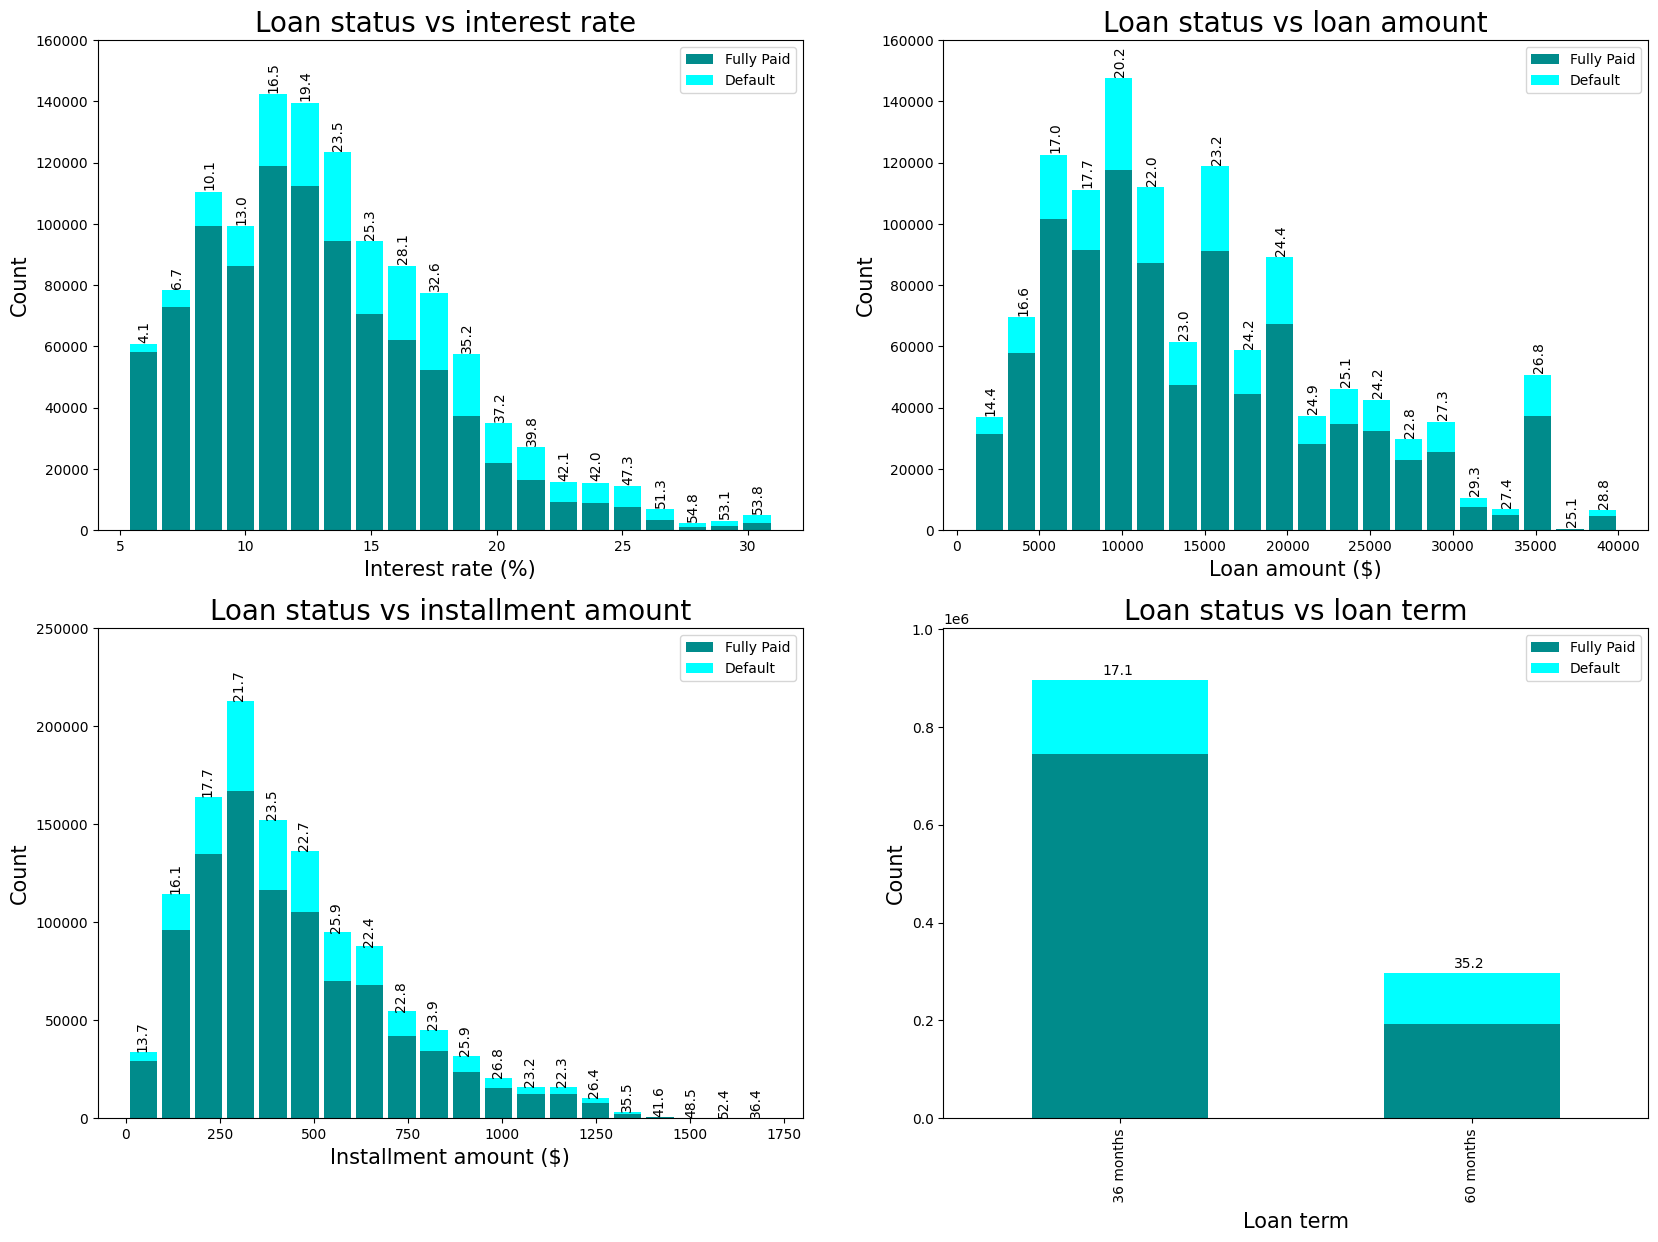

In [538]:
s1 = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'int_rate'], 'Default': df.loc[df['loan_status']=='Default', 'int_rate']}, index=None)
s2 = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'funded_amnt'], 'Default': df.loc[df['loan_status']=='Default', 'funded_amnt']}, index=None)
s3 = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'installment'], 'Default': df.loc[df['loan_status']=='Default', 'installment']})
s4 = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', ['term']].value_counts(), 'Default': df.loc[df['loan_status']=='Default', ['term']].value_counts()})
listIndex = s4.index

s4.index = [''.join(item) for item in listIndex]

fig, [(axes0, axes1), (axes2, axes3)] = plt.subplots(nrows = 2, ncols = 2, figsize=(20,14))

axes0.hist(s1, stacked=True, bins=20, rwidth=0.85, color=["darkcyan", "cyan"])
axes1.hist(s2, stacked=True, bins=20, rwidth=0.85, color=["darkcyan", "cyan"])
axes2.hist(s3, stacked=True, bins=20, rwidth=0.85, color=["darkcyan", "cyan"])
s4.plot.bar(stacked=True, ax=axes3, color=["darkcyan", "cyan"])

axes0.legend(['Fully Paid', 'Default'])
axes0.set_xlabel('Interest rate (%)', fontsize=15)
axes0.set_ylabel('Count', fontsize=15)
axes0.set_title("Loan status vs interest rate ", fontsize=20)
axes0.set_ylim(0,160000)

axes1.legend(['Fully Paid', 'Default'])
axes1.set_xlabel('Loan amount ($)', fontsize=15)
axes1.set_ylabel('Count', fontsize=15)
axes1.set_title('Loan status vs loan amount', fontsize=20)
axes1.set_ylim(0,160000)

axes2.legend(['Fully Paid', 'Default'])
axes2.set_xlabel('Installment amount ($)', fontsize=15)
axes2.set_ylabel('Count', fontsize=15)
axes2.set_title('Loan status vs installment amount', fontsize=20)
axes2.set_ylim(0,250000)

axes3.legend(['Fully Paid', 'Default'])
axes3.set_xlabel('Loan term', fontsize=15)
axes3.set_ylabel('Count', fontsize=15)
axes3.set_ylim(0,1002000)
axes3.set_title("Loan status vs loan term", fontsize=20)


p = axes0.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + .3
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 1500
    a = Y2/(Y2 + Y1)
    axes0.text(x, y, round(a*100,1), rotation=90)
    
p = axes1.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + 500
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 1500
    a = Y2/(Y2 + Y1)
    axes1.text(x, y, round(a*100,1), rotation=90)
    
p = axes2.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + 15
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 1500
    a = Y2/(Y2 + Y1)
    axes2.text(x, y, round(a*100,1), rotation=90)
    
p = axes3.patches
for i in range(0,2,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 +0.2
    Y1 = p[i].get_height()
    Y2 = p[i+2].get_height()
    y = Y2 + Y1 +10000
    a = Y2/(Y2 + Y1)
    axes3.text(x, y, round(a*100,1), rotation=0)
plt.show()    

Accoding the above figures, intresting conclusions are made. First of all, the loan intrest rate has huge impact on the percentage of the default. The more the intrest rate, the higher is the default rate. The loan amount, on the other hand, does not affect the default rate. We have a little bit lower chance of default for loans less than 10000 though. The installment amount has a significant effect on the default are. The higher the installment amount, the higher is the probability to default. Also, those with 60 months of loan term default their loans almost two times of the people with 60 months-term loans.

#### Loan status distribution vs previous history: charged off within 12 months

C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\2011802283.py:18: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)


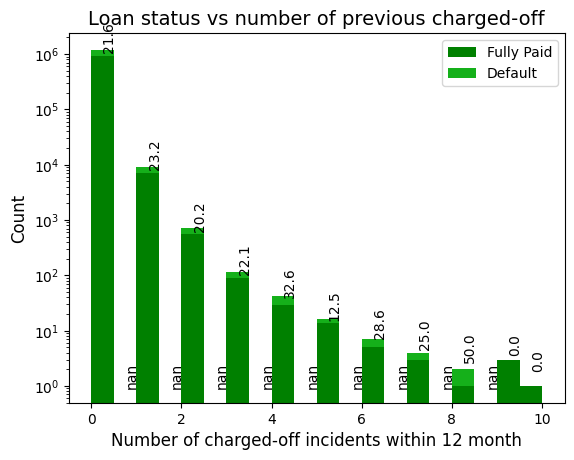

In [539]:
chargeoff_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'chargeoff_within_12_mths'], 
                   'Default': df.loc[df['loan_status']=='Default', 'chargeoff_within_12_mths']}, index=None)
fig, ax = plt.subplots()
ax.hist(chargeoff_df, stacked=True, bins=20, log = True, rwidth=None, color =['#008000', '#15B01A'])

ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Number of charged-off incidents within 12 month', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Loan status vs number of previous charged-off', fontsize=14)

p = ax.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x = x1 + p[i].get_width()/2. 
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 1
    a = Y2/(Y2 + Y1)
    ax.text(x, y, round(a*100,1), rotation=90)
plt.show()

As shown in the above figure, there is no clear relationship between the default percentage and the number of charged-off incidents within 12 months prior to the application for loan. Nevertheless, the number of granted loan has dropped tremendously with increasing the number of chrged-off accounts.

#### Loan status distribution vs previous history: banckruptcies

C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\2556394436.py:18: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)


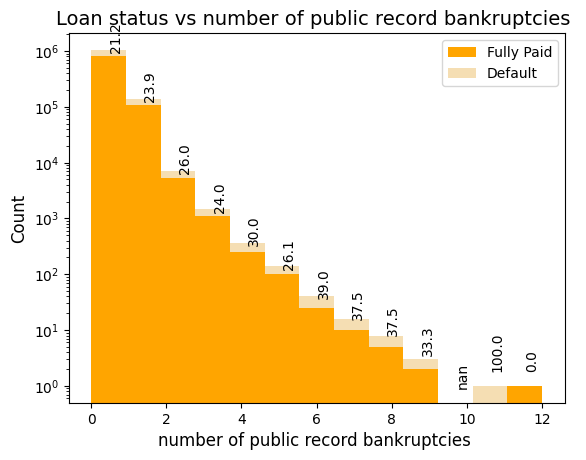

In [540]:
banckruptcy_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'pub_rec_bankruptcies'], 
                   'Default': df.loc[df['loan_status']=='Default', 'pub_rec_bankruptcies']}, index=None)
fig, ax = plt.subplots()
ax.hist(banckruptcy_df, stacked=True, bins=13, log = True, rwidth=None, color =['orange', 'wheat'])

ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('number of public record bankruptcies ', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Loan status vs number of public record bankruptcies ', fontsize=14)

p = ax.patches
for i in range(0,13,1):
    x1, y1 = p[i].get_xy()
    x = x1 + p[i].get_width()/2. 
    Y1 = p[i].get_height()
    Y2 = p[i+13].get_height()
    y = Y2 + Y1 + 1
    a = Y2/(Y2 + Y1)
    ax.text(x, y, round(a*100,1), rotation=90)
plt.show()

As shown in the above figure, although there is an increasing trend between the default percentage and the number of public banckruptcies prior to the application for loan, there is no definite correlation for over 10 banckruptcies. For instance, those having 11 banckruptcies show 100% default while those with 12 bancktrupcies show zero percentage for default. Nevertheless, the number of granted loan has dropped tremendously with increasing the number of chrged-off accounts.

#### Loan status distribution vs previous history: collections

C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\662467748.py:18: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)


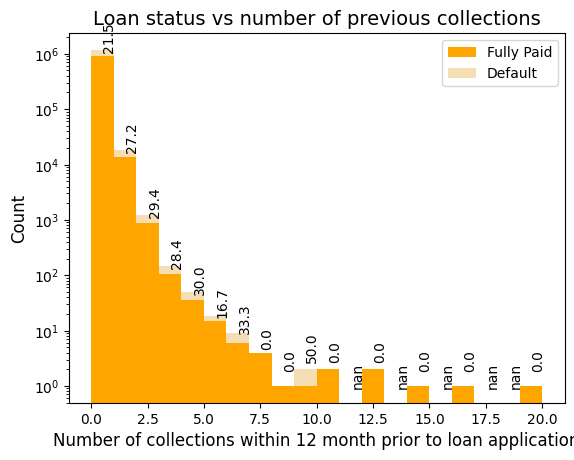

In [541]:
collection_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'collections_12_mths_ex_med'], 'Default': df.loc[df['loan_status']=='Default', 'collections_12_mths_ex_med']}, index=None)

fig, ax = plt.subplots()
ax.hist(collection_df, stacked=True, bins=20, log = True, rwidth=None, color =['orange', 'wheat'])

ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Number of collections within 12 month prior to loan application', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Loan status vs number of previous collections', fontsize=14)

p = ax.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x = x1 + p[i].get_width()/2. 
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 1
    a = Y2/(Y2 + Y1)
    ax.text(x, y, round(a*100,1), rotation=90)
plt.show()

As shown in the above figure, there is no clear relationship between the default percentage and the number of collections within 12 months prior to the application for loan. Nevertheless, the number of granted loan has dropped tremendously with increasing the number of collections.

#### Loan status distribution vs previous history: tax liens 

C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\2635342622.py:18: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)


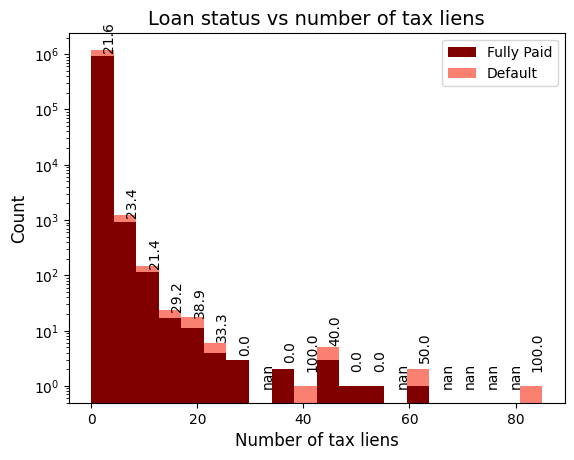

In [542]:
taxlien_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'tax_liens'], 
                   'Default': df.loc[df['loan_status']=='Default', 'tax_liens']}, index=None)
fig, ax = plt.subplots()
ax.hist(taxlien_df, stacked=True, bins=20, log = True, rwidth=None, color =['maroon', 'salmon'])

ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Number of tax liens', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Loan status vs number of tax liens', fontsize=14)

p = ax.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x = x1 + p[i].get_width()/2. 
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 1
    a = Y2/(Y2 + Y1)
    ax.text(x, y, round(a*100,1), rotation=90)
plt.show()

As shown in the above figure, there is no clear relationship between the default percentage and the number of tax liens prior to the application for loan. Nevertheless, the number of granted loan has dropped tremendously with increasing the number of tax liens.

#### Loan status distribution vs previous history: delinquent amount

C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\3100963632.py:18: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)


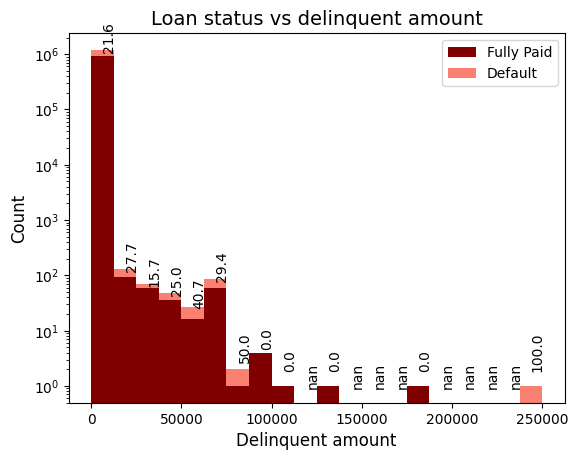

In [543]:
delinq_amnt_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'delinq_amnt'], 
                   'Default': df.loc[df['loan_status']=='Default', 'delinq_amnt']}, index=None)
fig, ax = plt.subplots()
ax.hist(delinq_amnt_df, stacked=True, bins=20, log = True, rwidth=None, color =['maroon', 'salmon'])

ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Delinquent amount', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Loan status vs delinquent amount', fontsize=14)

p = ax.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x = x1 + p[i].get_width()/2. 
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 1
    a = Y2/(Y2 + Y1)
    ax.text(x, y, round(a*100,1), rotation=90)
plt.show()

As shown in the above figure, although there is no clear relationship between the default percentage and the delinquent amount prior to the application for loan, all the applicants with more than 250000 delinquency, have defaulted their loans. Nevertheless, the number of granted loan has dropped tremendously with increasing the delinquent.

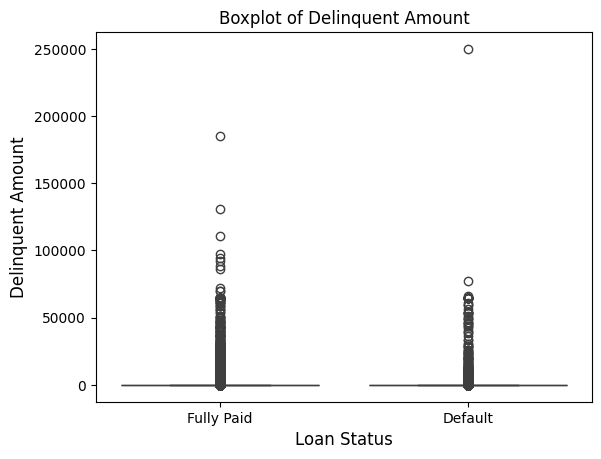

In [544]:
fig, ax = plt.subplots()
sns.boxplot(x = 'loan_status', y = 'delinq_amnt', data = df)
#ax.set_yscale("log")
ax.set_xlabel('Loan Status', fontsize=12)
ax.set_ylabel('Delinquent Amount', fontsize=12)
ax.set_title('Boxplot of Delinquent Amount')

plt.show()

In [545]:
Q1 = df['delinq_amnt'].quantile(0.25)
Q3 = df['delinq_amnt'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df['delinq_amnt'] >= Q1 - 1.5 * IQR) & (df['delinq_amnt'] <= Q3 + 1.5 *IQR)
df_delinq_amnt = df.loc[filter] 

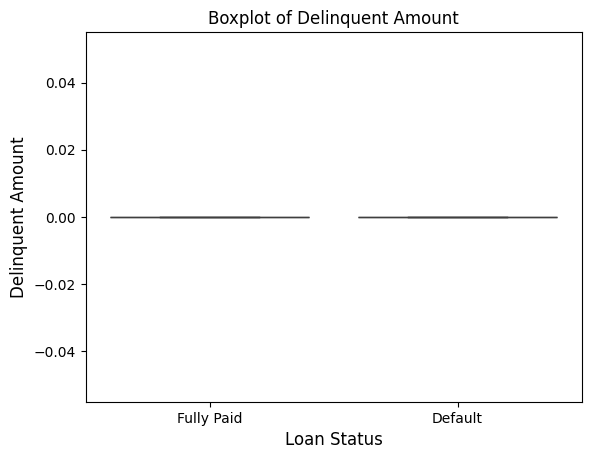

In [546]:
fig, ax = plt.subplots()
sns.boxplot(x = 'loan_status', y = 'delinq_amnt', data = df, showfliers=False)
#ax.set_yscale("log")
ax.set_xlabel('Loan Status', fontsize=12)
ax.set_ylabel('Delinquent Amount', fontsize=12)
ax.set_title('Boxplot of Delinquent Amount')

plt.show()

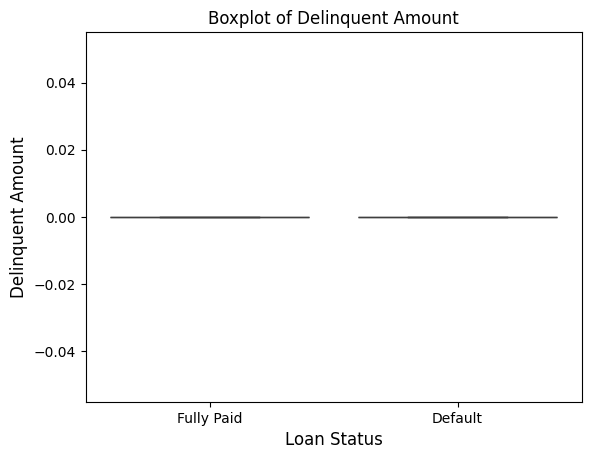

In [547]:
fig, ax = plt.subplots()
sns.boxplot(x = 'loan_status', y = 'delinq_amnt', data = df_delinq_amnt)
#ax.set_yscale("log")
ax.set_xlabel('Loan Status', fontsize=12)
ax.set_ylabel('Delinquent Amount', fontsize=12)
ax.set_title('Boxplot of Delinquent Amount')

plt.show()

In [548]:
Q1, Q3

(0.0, 0.0)

#### Loan status distribution vs previous history: number of delinquency in the past 2 years

C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\1160331121.py:18: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)


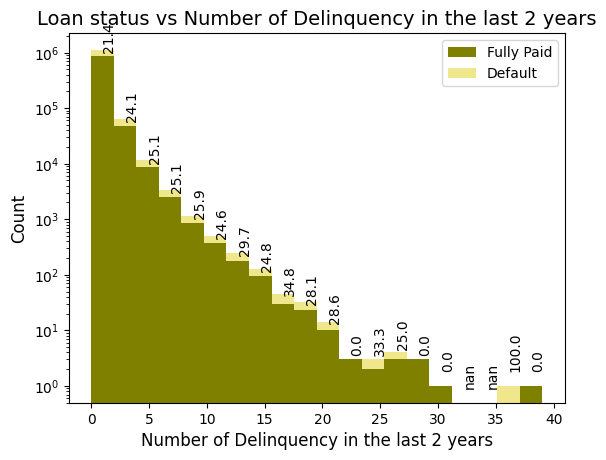

In [549]:
delinq_2yrs_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'delinq_2yrs'], 
                   'Default': df.loc[df['loan_status']=='Default', 'delinq_2yrs']}, index=None)
fig, ax = plt.subplots()
ax.hist(delinq_2yrs_df, stacked=True, bins=20, log = True, rwidth=None, color =['olive', 'khaki'])

ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Number of Delinquency in the last 2 years', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Loan status vs Number of Delinquency in the last 2 years', fontsize=14)

p = ax.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x = x1 + p[i].get_width()/2. 
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 1
    a = Y2/(Y2 + Y1)
    ax.text(x, y, round(a*100,1), rotation=90)
plt.show()

#### Loan status distribution vs previous history: number of accounts delinquent now

C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\745710050.py:18: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)


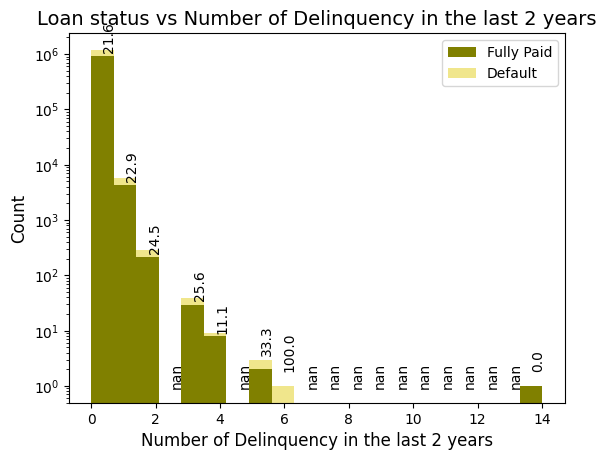

In [550]:
account_delinq_now_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'acc_now_delinq'], 
                   'Default': df.loc[df['loan_status']=='Default', 'acc_now_delinq']}, index=None)
fig, ax = plt.subplots()
ax.hist(account_delinq_now_df, stacked=True, bins=20, log = True, rwidth=None, color =['olive', 'khaki'])

ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Number of Delinquency in the last 2 years', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Loan status vs Number of Delinquency in the last 2 years', fontsize=14)

p = ax.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x = x1 + p[i].get_width()/2. 
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 1
    a = Y2/(Y2 + Y1)
    ax.text(x, y, round(a*100,1), rotation=90)
plt.show()

#### Loan status distribution vs utilization rate, revolving balance and inquires within 6 month of loan application

C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\489835322.py:46: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)
C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\489835322.py:58: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

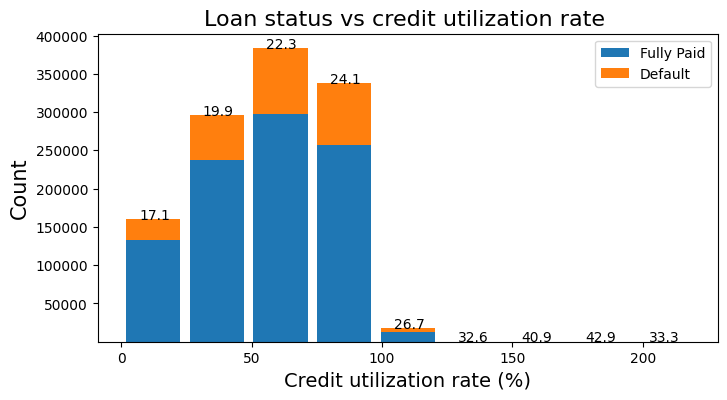

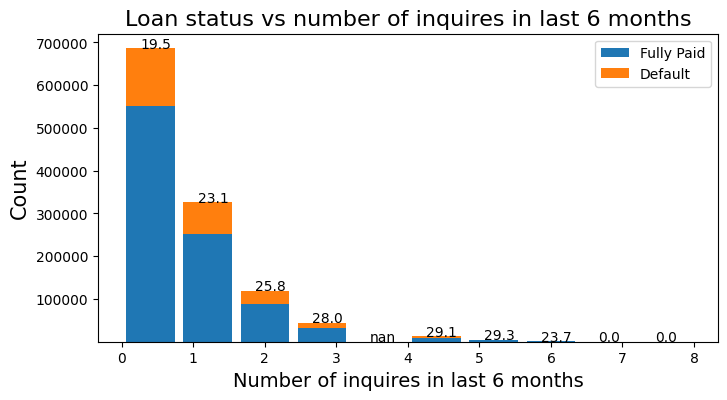

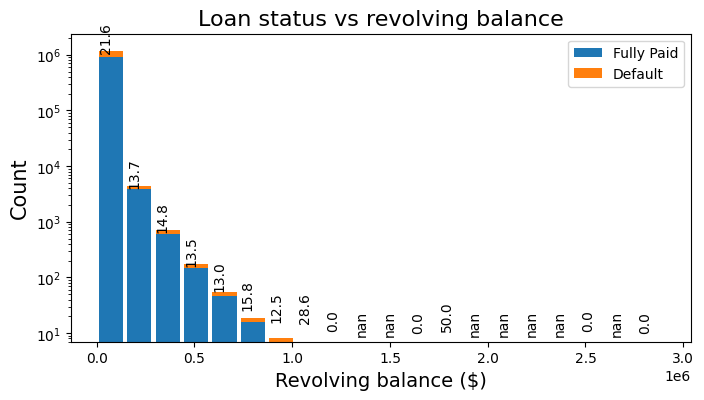

In [551]:
util_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'util'], 'Default': df.loc[df['loan_status']=='Default', 'util']}, index=None)
inq_last_6mths_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'inq_last_6mths'], 'Default': df.loc[df['loan_status']=='Default', 'inq_last_6mths']}, index=None)
revol_bal_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'revol_bal'], 'Default': df.loc[df['loan_status']=='Default', 'revol_bal']}, index=None)

plt.figure()
fig, axes = plt.subplots(3,1) 
fig.clf()
axes[0] = util_df.plot.hist(stacked=True, bins=9, rwidth=0.85, figsize=(8,4))
axes[1] = inq_last_6mths_df.plot.hist(stacked=True, bins=10, rwidth=0.85, figsize=(8,4))
axes[2] = revol_bal_df.plot.hist(stacked=True, bins=20, log=True, rwidth=0.85, figsize=(8,4))

axes[0].legend(['Fully Paid', 'Default'])
axes[0].set_xlabel('Credit utilization rate (%)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=15)
axes[0].set_title("Loan status vs credit utilization rate ", fontsize=16)

axes[1].legend(['Fully Paid', 'Default'])
axes[1].set_xlabel('Number of inquires in last 6 months', fontsize=14)
axes[1].set_ylabel('Count', fontsize=15)
axes[1].set_title('Loan status vs number of inquires in last 6 months', fontsize=16)

axes[2].legend(['Fully Paid', 'Default'])
axes[2].set_xlabel('Revolving balance ($)', fontsize=14)
axes[2].set_ylabel('Count', fontsize=15)
axes[2].set_title('Loan status vs revolving balance', fontsize=16)

p = axes[0].patches
for i in range(0,9,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + 5
    Y1 = p[i].get_height()
    Y2 = p[i+9].get_height()
    y = Y2 + Y1 + p[i].get_width()
    a = Y2/(Y2 + Y1)
    axes[0].text(x, y, round(a*100,1), rotation=0) 

p = axes[1].patches
for i in range(0,10,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1+.2 
    Y1 = p[i].get_height()
    Y2 = p[i+10].get_height()
    y = Y2 + Y1 + p[i].get_width()
    a = Y2/(Y2 + Y1)
    axes[1].text(x, y, round(a*100,1), rotation=0)   

    
p = axes[2].patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + math.log10(p[i].get_width())
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 10
    a = Y2/(Y2 + Y1)
    axes[2].text(x, y, round(a*100,1), rotation=90)
    

plt.show()

#### Loan status distribution vs length of credit 

C:\Users\srafi\AppData\Local\Temp\ipykernel_18716\1382571319.py:19: RuntimeWarning: invalid value encountered in scalar divide
  a = Y2/(Y2 + Y1)


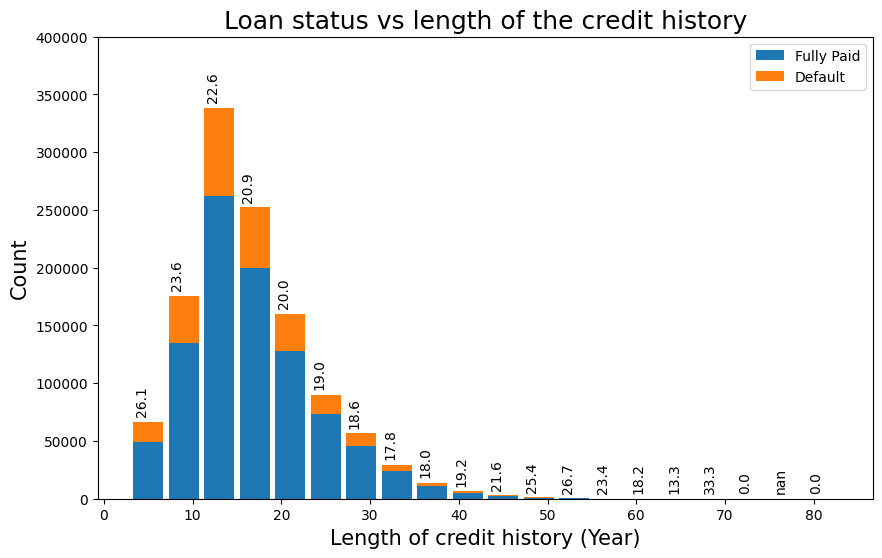

In [552]:
df['Credit Length (year)'] = (df['issue_d'].apply(lambda x:x.year)-df['earliest_cr_line'].apply(lambda x:x.year))
length_credit_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'Credit Length (year)'], 'Default': df.loc[df['loan_status']=='Default', 'Credit Length (year)']}, index=None)
ax = length_credit_df.plot.hist(stacked=True, bins=20, figsize=(10, 6), rwidth=0.85)

ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Length of credit history (Year)', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title("Loan status vs length of the credit history", fontsize=18)
ax.set_ylim(0,400000)

p = ax.patches
for i in range(0,20,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + 0.2
    Y1 = p[i].get_height()
    Y2 = p[i+20].get_height()
    y = Y2 + Y1 + 7000
    a = Y2/(Y2 + Y1)
    plt.text(x, y, round(a*100,1), rotation=90)

According to the above analysis, the credit history of an applicant does not affect the default of a loan. It however, has affected the number of loans granted.

#### Does the Debt To Income (DTI) ratio affect the borrowers's defaulting a loan or not?

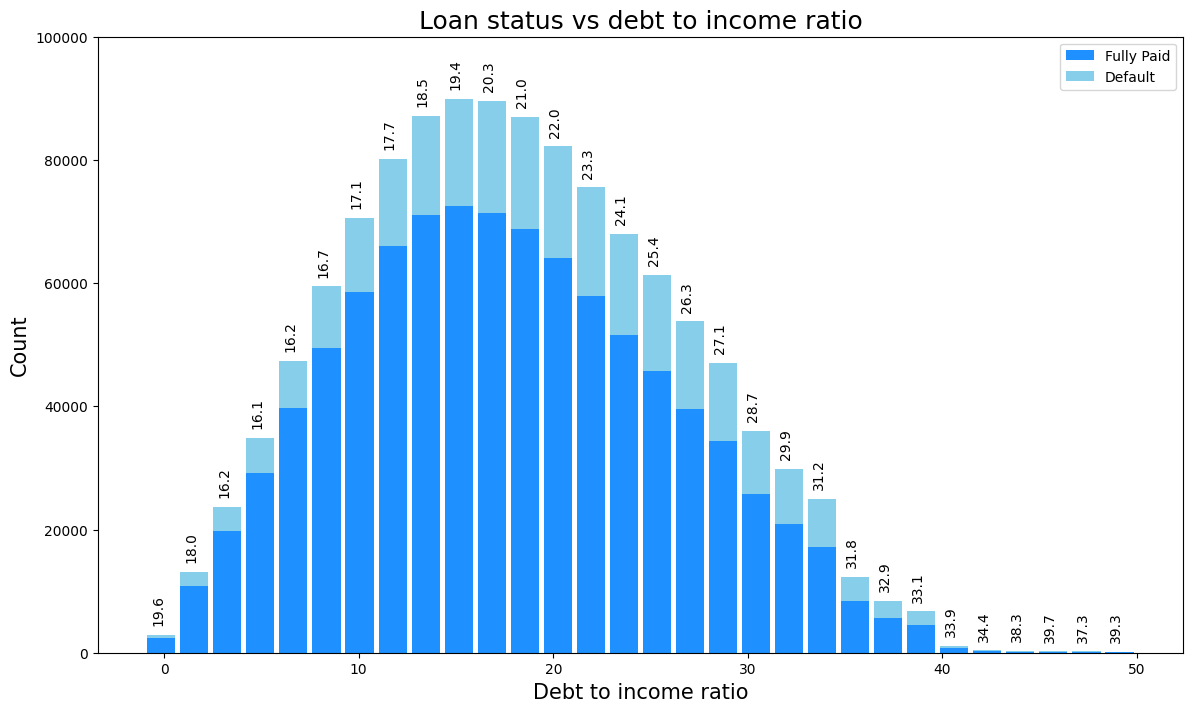

In [553]:
dti_df = pd.DataFrame({'Fully Paid': df.loc[df['loan_status']=='Fully Paid', 'dti'], 'Default': df.loc[df['loan_status']=='Default', 'dti']}, index=None)
ax = dti_df.plot.hist(stacked=True, bins=30, figsize=(14, 8), rwidth=0.85, color=["dodgerblue", "skyblue"])

ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('Debt to income ratio', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title("Loan status vs debt to income ratio", fontsize=18)
ax.set_ylim(0,100000)

p = ax.patches
heights = [patch.get_height() for patch in p]

for i in range(0,30,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 +.2
    Y1 = p[i].get_height()
    Y2 = p[i+30].get_height()
    y = Y2 + Y1 + 2000
    a = Y2/(Y2 + Y1)
    plt.text(x, y, round(a*100,1), rotation=90)
plt.show()

According to the above figure, the applicants with higher dti ratio will default their loans more. So this will be an important factor for the lenders to decide whether to grant a loan to the applicants simply based on theri finincial commitments.

#### Does geographical location of the applicant affects the default of a granted loan?

In [554]:
state_summary_df = pd.read_csv(state_summary)
# source https://corgis-edu.github.io/corgis/csv/state_demographics/

In [555]:
states_name_df = pd.read_csv(states_name)

In [556]:
joined_state_summary = state_summary_df.join(states_name_df.set_index('State'), on='State', how='left', lsuffix='', 
                                             rsuffix='', sort=False, validate=None)

In [557]:
df1 = pd.merge(df, joined_state_summary, how='left', left_on = 'addr_state', right_on = 'Abbreviation')

In [558]:
joined_state_summary.columns

Index(['State', 'Population.2014 Population', 'Population.2010 Population',
       'Abbreviation'],
      dtype='object')

posx and posy should be finite values
posx and posy should be finite values


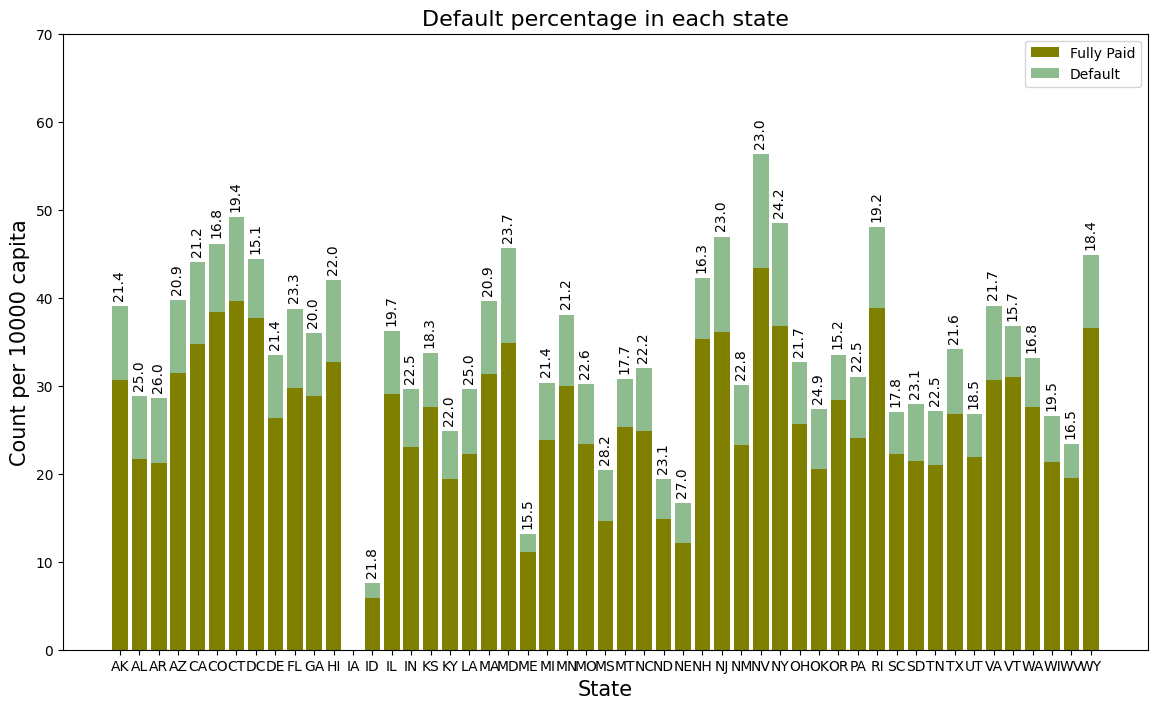

In [559]:
# Count the number of fully paid and defaulted loans in each state
addr_state_df = pd.DataFrame({'Default': df.loc[df['loan_status']=='Default', ['addr_state']].value_counts(),
                  'Fully Paid': df.loc[df['loan_status']=='Fully Paid', ['addr_state']].value_counts()})
listIndex = addr_state_df.index

addr_state_df.index = [''.join(item) for item in listIndex]
addr_state_df1 = addr_state_df.join(joined_state_summary.set_index('Abbreviation')) \
                    .drop(['State', 'Population.2010 Population'], axis=1).rename(columns={'Population.2014 Population':'population'})

addr_state_df1['Total'] = addr_state_df1['Default'] + addr_state_df1['Fully Paid']
addr_state_df1['Default_per_10000'] = addr_state_df1['Default']/addr_state_df1['population']*10000
addr_state_df1['FullyPaid_per_10000'] = addr_state_df1['Fully Paid']/addr_state_df1['population']*10000

fig, ax =plt.subplots(nrows=1, ncols=1, figsize=(14,8))

ax.bar(addr_state_df1.index, addr_state_df1['FullyPaid_per_10000'], color="olive")
ax.bar(addr_state_df1.index, addr_state_df1['Default_per_10000'], bottom=addr_state_df1['FullyPaid_per_10000'], color="darkseagreen")
ax.set_ylabel('Count per 10000 capita', fontsize=15)
ax.legend(['Fully Paid', 'Default'])
ax.set_xlabel('State', rotation=0, fontsize=15)
ax.set_title('Default percentage in each state', fontsize=16)
ax.set_ylim([0,70])
p = ax.patches
heights = [patch.get_height() for patch in p]

length = len(addr_state_df.index )
for i in range(0,length,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 
    Y1 = p[i].get_height()
    Y2 = p[i+length].get_height()
    y = Y2 + Y1 + 1
    a = Y2/(Y2 + Y1)
    plt.text(x, y, round(a*100,1), rotation=90)

plt.show()



According to the above figure, the percentage of default per 10000 capita ranges from 15 to 29. NV has the highest number of loans issued per 10,000 capita and IA has the lowest number of loans issued per 10,000 capita. However, 50% of loans issued in IA are finally defaulted. Does this mean that IA residents perform significantly worse than other states' residents? To answer this question, we had a closer look at IA. There are only two loans issued in this state, which is a very small number to make any hypothesis.

In [560]:
df.columns

Index(['dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'inq_last_6mths', 'earliest_cr_line', 'open_acc', 'mort_acc',
       'annual_inc', 'issue_d', 'grade', 'sub_grade', 'funded_amnt',
       'loan_status', 'installment', 'int_rate', 'term', 'revol_bal',
       'fico_range_high', 'fico_range_low', 'emp_length', 'home_ownership',
       'funded_amnt_inv', 'num_rev_accts', 'pub_rec_bankruptcies', 'tax_liens',
       'addr_state', 'loan_amnt', 'purpose', 'verification_status',
       'tot_hi_cred_lim', 'pub_rec', 'delinq_2yrs', 'delinq_amnt',
       'acc_now_delinq', 'util', 'Credit Length (year)'],
      dtype='object')

### Principal Component Analysis

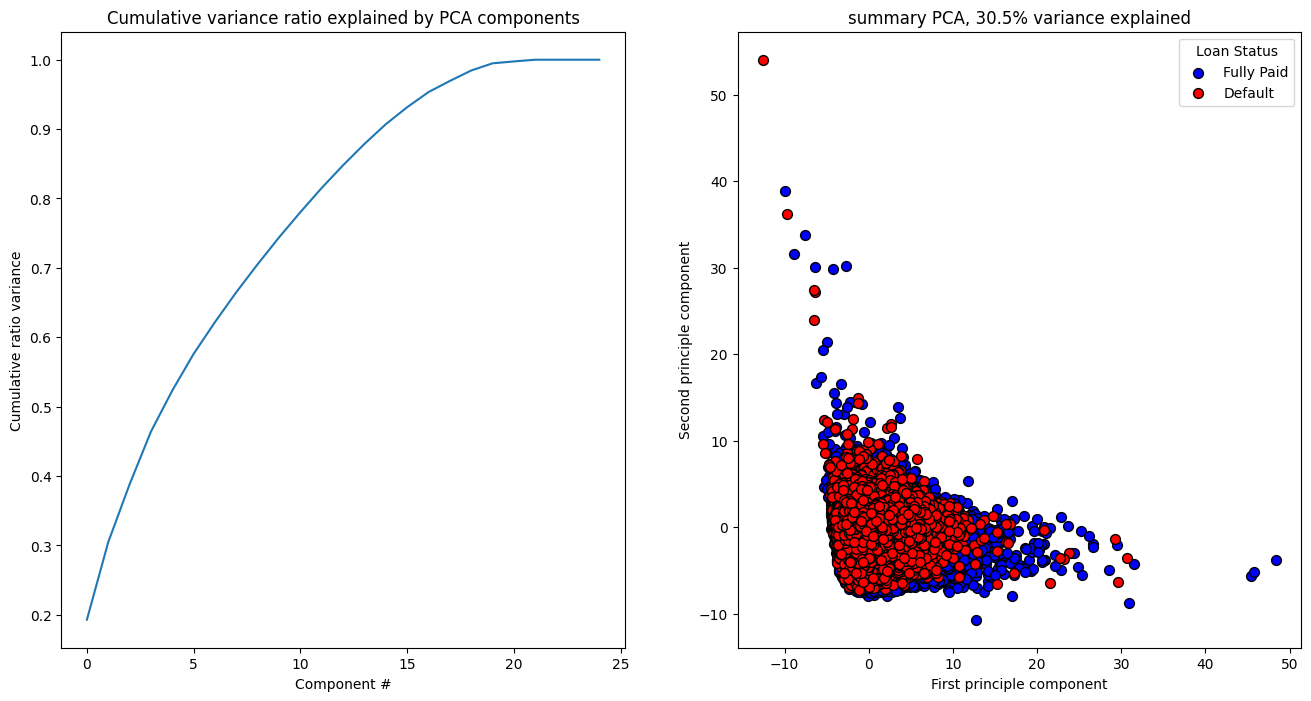

In [563]:
Y = df['loan_status']
X_numeric = df.select_dtypes(np.number)
X = X_numeric.drop(columns=['issue_year'])
cols = X.columns
X_scaled = pd.DataFrame(scale(X), columns = cols)
pca = PCA()

df_pca = pca.fit(X_scaled)
df_loadings = df_pca.components_
df_loadings = pd.DataFrame(df_loadings, columns=cols)
df_pca_x = df_pca.transform(X_scaled)
df_PCA_x = pd.DataFrame(df_pca_x, index=X.index)
X_pca = df_PCA_x.loc[:, 0:1]

data = X_pca.join(Y)
data.columns = ['PCA1', 'PCA2', 'Status']

fig, axes =plt.subplots(nrows=1, ncols=2, figsize=(16,8))
axes[0].plot(df_pca.explained_variance_ratio_.cumsum())
axes[0].set_xlabel('Component #')
axes[0].set_ylabel('Cumulative ratio variance')
axes[0].set_title('Cumulative variance ratio explained by PCA components');

# Plot
axes[1].scatter(data.loc[data['Status']=='Fully Paid', 'PCA1'], data.loc[data['Status']=='Fully Paid', 'PCA2'], c='blue', edgecolor='k', s=50, label='Fully Paid')
axes[1].scatter(data.loc[data['Status']=='Default', 'PCA1'], data.loc[data['Status']=='Default', 'PCA2'], c='red', edgecolor='k', s=50, label='Default')
pc_var = 100 * df_pca.explained_variance_ratio_.cumsum()[1]

axes[1].set_xlabel('First principle component')
axes[1].set_ylabel('Second principle component')
axes[1].set_title(f'summary PCA, {pc_var:.1f}% variance explained')
axes[1].legend(loc='best', title='Loan Status', fontsize=10)
plt.show();


In [564]:
df['fico_score'] = np.mean([df['fico_range_high'], df['fico_range_low']])

In [565]:
df.columns

Index(['dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'inq_last_6mths', 'earliest_cr_line', 'open_acc', 'mort_acc',
       'annual_inc', 'issue_d', 'grade', 'sub_grade', 'funded_amnt',
       'loan_status', 'installment', 'int_rate', 'term', 'revol_bal',
       'fico_range_high', 'fico_range_low', 'emp_length', 'home_ownership',
       'funded_amnt_inv', 'num_rev_accts', 'pub_rec_bankruptcies', 'tax_liens',
       'addr_state', 'loan_amnt', 'purpose', 'verification_status',
       'tot_hi_cred_lim', 'pub_rec', 'delinq_2yrs', 'delinq_amnt',
       'acc_now_delinq', 'util', 'Credit Length (year)', 'issue_year',
       'fico_score'],
      dtype='object')

In [566]:
df.drop(columns = ['issue_d', 'addr_state', 'issue_year', 'earliest_cr_line', 'funded_amnt', 'funded_amnt_inv',
                  'fico_range_high', 'fico_range_low', 'grade', 'acc_now_delinq'], inplace=True)

In [567]:
SavePath = os.path.join(PROJ_ROOT,'data', 'explored_cleaned', "cleaned_data_EDA.csv")
df.to_csv(SavePath, sep=',')